In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint, quad
import random
from __future__ import division

In [2]:
plt.rc('font', family='serif', size=8)
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='cm')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=20)
plt.rc('figure', titlesize=15)

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

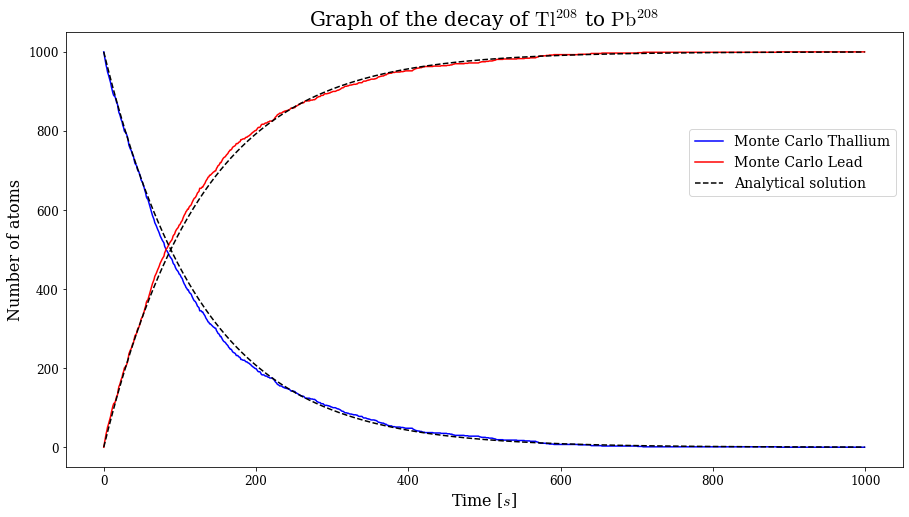

In [3]:
t_half_tha   = 3.052 * 60 #in seconds
tau          = t_half_tha * np.log(2)
N0           = 1000
t1           = 1000 #time window
n_timepoints = 1000 #steps in time of 1s

def analytic_solution(N0, timebase):
    return N0 * np.exp(-timebase / tau), N0 * (1 - np.exp(-timebase / tau))

def monte_carlo(N0, t1, n_timepoints):
    dt = t1 / n_timepoints
    count_thallium = np.zeros((n_timepoints))
    count_lead = np.zeros((n_timepoints))
    atoms = np.ones((N0))
    p_decay_tha = 1 - np.exp(-dt / tau)
    
    for idx_time in range(n_timepoints):
        count_thallium[idx_time]   = (atoms == 1).sum()
        count_lead[idx_time] = (atoms == 2).sum()
        
        for idx_atom in range(N0):
            if atoms[idx_atom] == 1: #deciding whether the given atom should decay
                if random.random() <= p_decay_tha:
                    atoms[idx_atom] = 2
                else:
                    atoms[idx_atom] = 1
                
    return count_thallium, count_lead

timebase = np.arange(0, t1, t1/n_timepoints) #array of times
n_analytic_tha, n_analytic_lea = analytic_solution(N0,  timebase)
n_tha, n_lea = monte_carlo(N0, t1, n_timepoints)

plt.figure(figsize=(15, 8))
plt.plot(timebase, n_tha, label = 'Monte Carlo Thallium', color = 'blue')
plt.plot(timebase, n_lea, label = 'Monte Carlo Lead', color = 'red')
plt.plot(timebase, n_analytic_tha, label = 'Analytical solution', color = 'black', linestyle = '--')
plt.plot(timebase, n_analytic_lea, color = 'black', linestyle = '--')
plt.title('Graph of the decay of $\mathrm{Tl}^{208}$ to $\mathrm{Pb}^{208}$')
plt.ylabel('Number of atoms', size=16)
plt.xlabel('Time [$s$]', size=16)
plt.legend(prop={'size': 14}, bbox_to_anchor=(1,0.7), loc='right') 
plt.show()

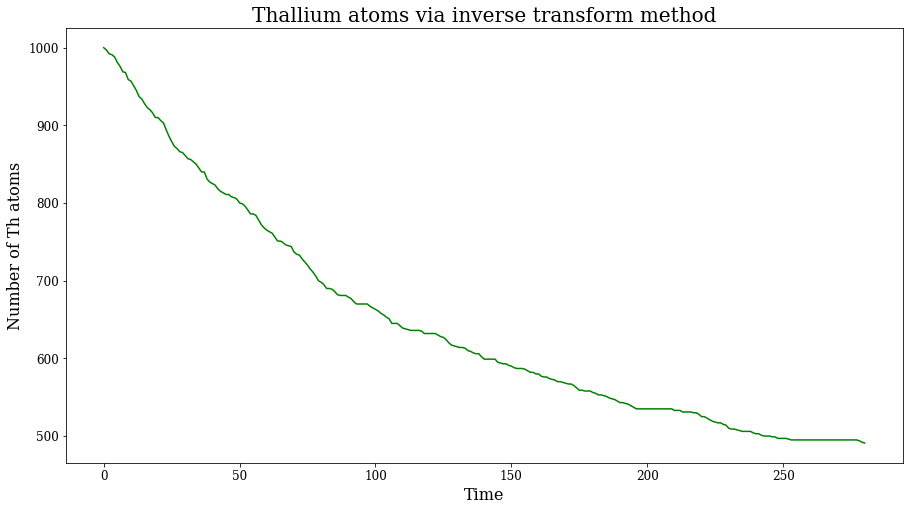

In [4]:
def itm(z, tau = tau): #inverse transform method
    return -tau*np.log2(1-z)

times, count = itm(np.random.random(1000)), np.zeros((1000))
times = np.sort(times)

i, k = 0, 0
for time in times:
    if time <= i: count[i] += 1
    else: i += 1

for j in range(len(count)):
    x = np.sum(count[:j])
    if x == np.sum(count): break
    k += 1
        
time = np.arange(0, len(count[:k]))
remaining = 1000 - np.cumsum(count[:k])

plt.figure(figsize=(15, 8))
plt.plot(time, remaining, color = 'green')
plt.title('Thallium atoms via inverse transform method')
plt.ylabel('Number of Th atoms', size=16)
plt.xlabel('Time', size=16)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [5]:
Z = 79
e = 1.602e-19
E = 7.7e6*e
eps0 = 8.854e-12
a0 = 5.292e-11
sigma = a0/100
N = int(1e6)

def gaussian():
    r = np.sqrt(-2*sigma**2*np.log(1 - np.random.random()))
    theta = 2*np.pi*np.random.random()
    x, y = r*np.cos(theta), r*np.sin(theta)
    return x, y

count = 0
for i in range(N):
    x, y = gaussian()
    b = np.sqrt(x**2 + y**2)
    if b < Z*e**2/(2*np.pi*eps0*E):
        count += 1

print(count,"alpha particles were reflected, the", count*100/N, "% out of 1 million shot.")

1547 alpha particles were reflected, the 0.1547 % out of 1 million shot.


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [6]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

N, count = int(1e4), 0

for i in range(N):
    x = 2*np.random.random()
    y = np.random.random()
    if y < f(x): count+=1
I = 2*count/N

p = count/N
err = 2*np.sqrt(N*p*(1-p))/N

print("Hit/miss method:")
print("The integral is {:.4} with error {:.2}, assuming data are drawn from a binomial distribution.\n".format(I, err))

random_arr = np.array([f(np.random.uniform(0, 2)) for i in range(N)])
res = sum(random_arr)
I_mean = 2*res/N
err_mean = 2*np.sqrt(sum(random_arr**2)/N - (res/N)**2)/np.sqrt(N)

diff_err = err_mean/err #comparison

print("Mean value method:")
print("The integral is {:.4} with error {:.2}, smaller by a factor {:.2} wrt the one obtained with the hit/miss method.".format(I_mean, err_mean, diff_err))

Hit/miss method:
The integral is 1.456 with error 0.0089, assuming data are drawn from a binomial distribution.

Mean value method:
The integral is 1.452 with error 0.0052, smaller by a factor 0.59 wrt the one obtained with the hit/miss method.


Based on the absolute value of the error, one can conclude that uniform sampling is more efficient than hit and miss method. However, computational time should also be taken into account.

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [7]:
def area(N = 10000, dimensions = 2):
    counts_in, counts, points = 0, 0, N*dimensions
    for i in range(points):
        coord = np.array([(np.random.uniform(-1, 1)) for i in range(dimensions)]) #coordinates on columns
        origin_dist = sum(map(lambda x:x*x, coord))
        if origin_dist <= 1: counts_in += 1
        counts += 1
    return (2**dimensions)*counts_in/counts
        
print("For r = 1:\n Area of a circle: {}\n Volume of a sphere: {:.5}\n For a 10D sphere, V = {}".format(area(), area(dimensions=3), area(dimensions=10)))

For r = 1:
 Area of a circle: 3.1272
 Volume of a sphere: 4.1808
 For a 10D sphere, V = 2.68288


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [8]:
def f(x): return 1/(np.sqrt(x)*(np.exp(x)+1))
def w(x): return 1/np.sqrt(x)

N, res = int(1e3), 0

first = True
for i in range(N):
    r = np.random.uniform(0, 1)**2 #x_i drawn from w(x) via inverse transform method
    if first:
        func = np.array([f(r)])
        wunc = np.array([w(r)])
        first = False
    else:
        func = np.append(func, f(r))
        wunc = np.append(wunc, w(r))
        
I = 2*sum(func/wunc)/N

print(I)

0.8376463967576205


If $w(x) = A\cdot \frac{1}{\sqrt{x}}$, $A$ is the normalising factor obtained by setting $\int^1_0 w(x) dx = 1 \rightarrow A=1/2$. Then, by applying the inverse transform method, $\int^{x(z)}_0 \frac{1}{2\sqrt{x}}=z$, which yields to the solution $x(z)=z^2$, $z$ being a uniform distributed variable between $0$ and $1$.